<a href="https://colab.research.google.com/github/EduardoLawson1/Pytorch-Practice/blob/main/Pytorch%20Paper%20Replicating/Pytorch_Paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Project 2: Pytorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research
paper into usable code.

## 0. Get setup

Let's import code previously written and libraries.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The goal here, is replicate the ViT architecture for our FoodVision Mini Problem

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
import os
from going_modular.going_modular import data_setup
from torchvision import transforms

#Create image size
IMG_SIZE = 224 # Comes from table 3 of the ViT paper

manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor(),
])

print(f"Manually crated transforms {manual_transforms}")

Manually crated transforms Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Creating dataloaders
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=BATCH_SIZE,
                                                                    num_workers=os.cpu_count())

len(train_dataloader), len(test_dataloader), class_names
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e84fde6b1d0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 VIsualize a single image

As always, let's adhere to the motto, visualize, visualize!

In [9]:
# Get a batch of images

image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

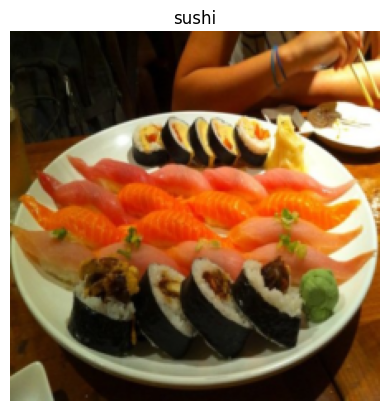

In [10]:
# Plot the image with matplotlib

import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview
Before we write any more code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our model inputs are: images of pizza, steak and sushi.

And our ideal model outputs are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?

## 4. Equation 1: Split daa into patches and creating the class, position and patch embedding

 Layers = input -> function -> output

 What's the input shape?

 What's the output shape?

 * Input shape: (224, 224, 3) -> Single image (height, width, color channels)

 * Output shape: ${N \times\left(P^{2} \cdot C\right)}$
 * H = Heigth
 * W = Width
 * C = Color channels
 * P = Patch size
 * N = number of patches = (height * width) / p^2
 * D = constant latent vector size = embedding dimension

In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f" Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

 Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Let's visualize, visualize, visualize!

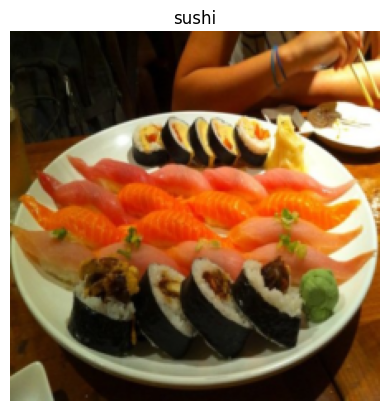

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [14]:
image.shape

torch.Size([3, 224, 224])

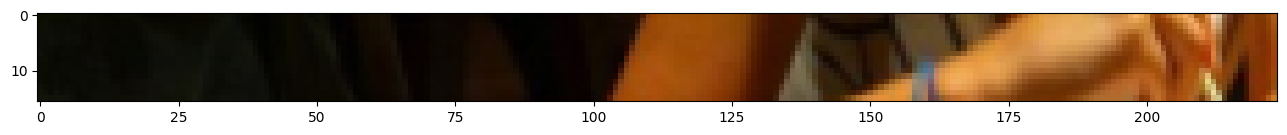

In [15]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert to color channels last
# Index to plot the top row of pixeçs
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


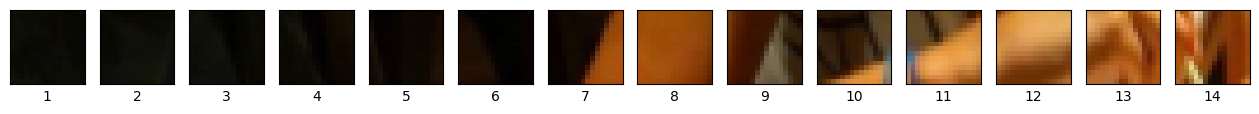

In [16]:
# Setup code to plot top row as patches
img_size = 224
patch_size =16
num_patches = img_size/patch_size
assert img_size % patch_size == 0

print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per colum: 14.0  
Total patches: 196.0  
Parch size: 16 pixels x 16 pixels


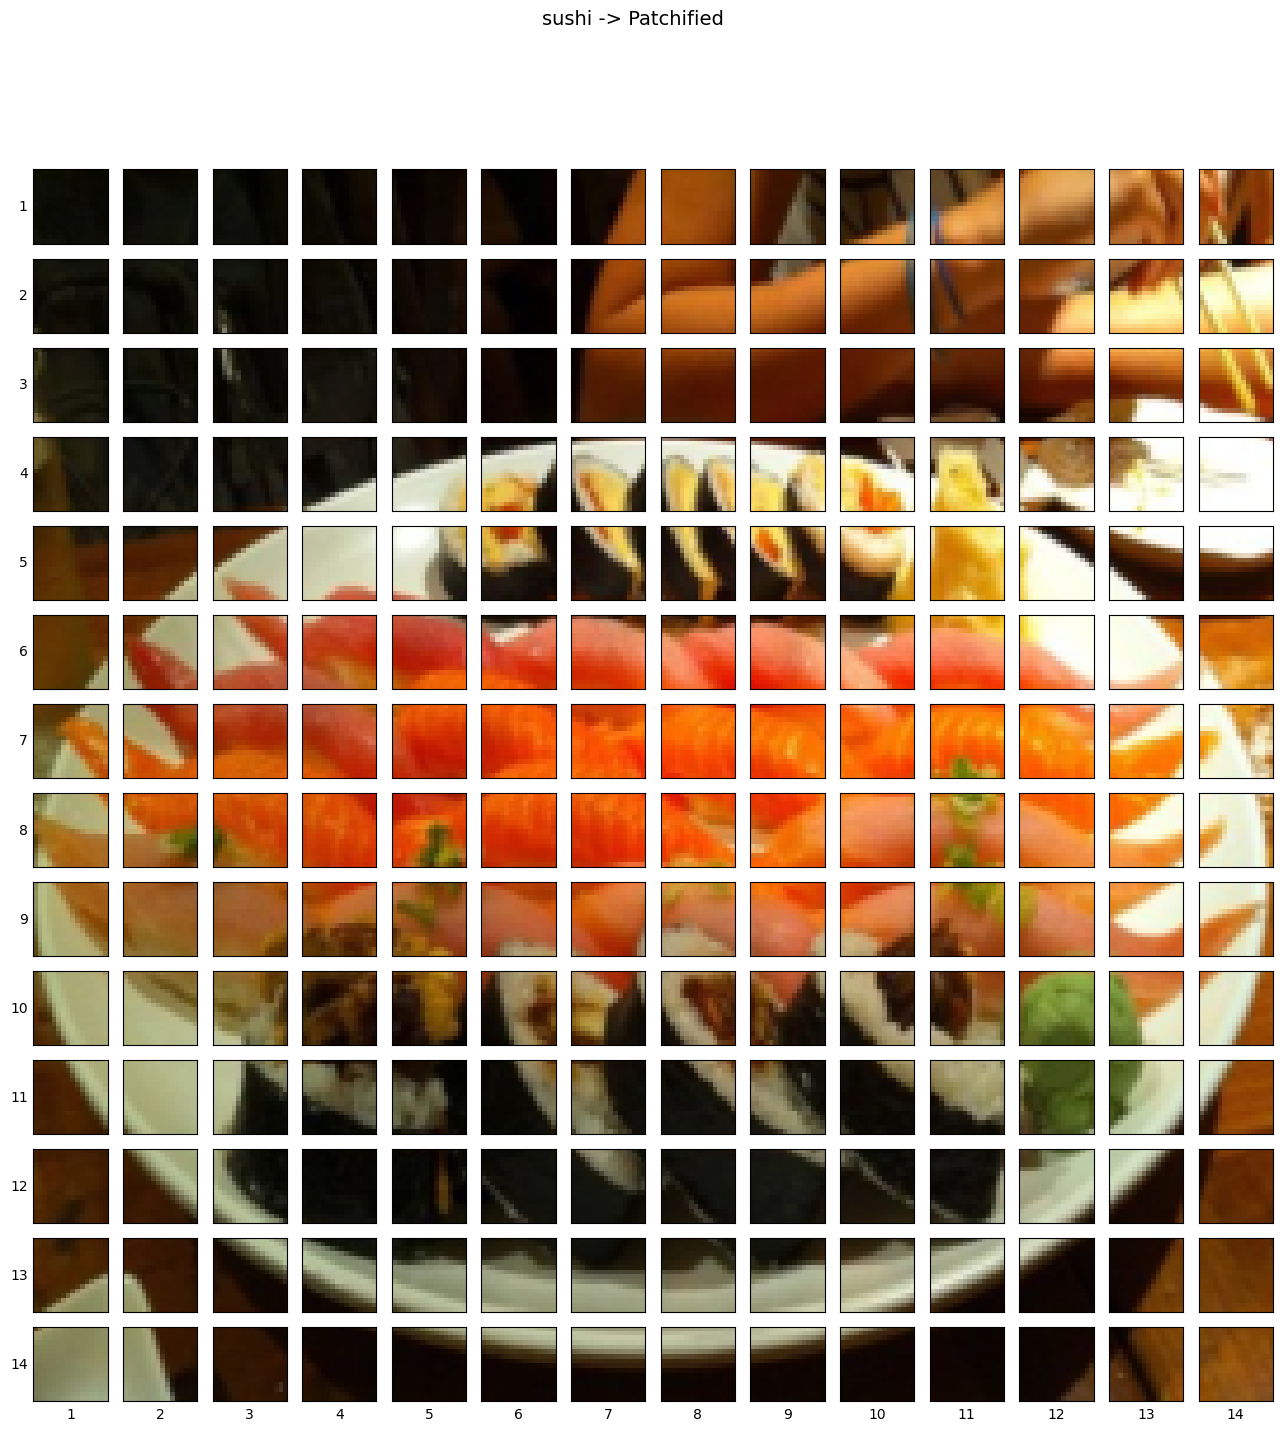

In [17]:
# Setup code to plot whole image as patches
img_size = 224
patch_size =16
num_patches = img_size/patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per colum: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nParch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                       ncols=img_size // patch_size,
                       figsize=(patch_size, patch_size),
                       sharex=True,
                       sharey=True)

# Loop through heigth and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): #height
 for j, patch_width in enumerate(range(0, img_size, patch_size)):
  # Plot the permuted image on the diferent axes
  axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                  patch_width:patch_width+patch_size, # iterate through width
                                  :])
  # Set up label information for each subplot (patch)
  axs[i, j].set_ylabel(i+1,
                       rotation="horizontal",
                       horizontalalignment="right",
                       verticalalignment="center")
  axs[i,j].set_xlabel(j+1)
  axs[i, j].set_xticks([])
  axs[i, j].set_yticks([])
  axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

In [18]:
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2D lauer with hyperparameters from ViT
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

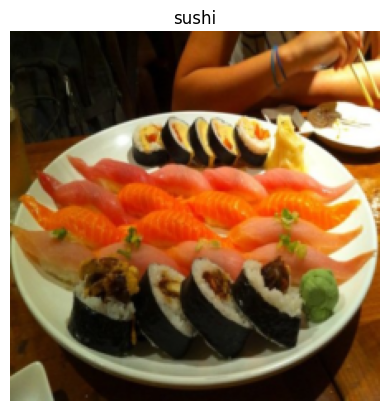

In [19]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [21]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes [218, 339, 485, 148, 394]


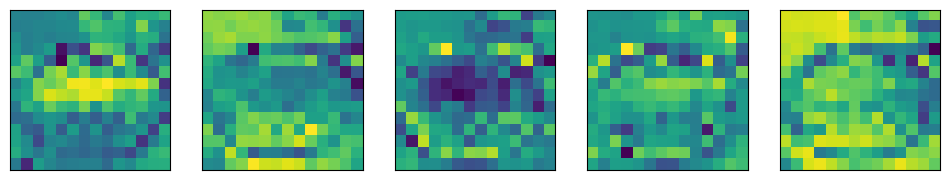

In [22]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes {random_indexes}")
# Create plots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # Index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [23]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0060,  0.0127,  0.0155,  0.0182, -0.0067, -0.0091,  0.0694,
            0.1836,  0.1110,  0.1256,  0.2581,  0.3368,  0.2892,  0.3333],
          [ 0.0101,  0.0227,  0.0010,  0.0230,  0.0125, -0.0207,  0.1891,
            0.2371,  0.1250,  0.3318,  0.1151,  0.3281,  0.3044,  0.3898],
          [ 0.0093,  0.0269,  0.0658,  0.0312, -0.0027,  0.0063,  0.1256,
            0.1153,  0.0612,  0.0689,  0.0476,  0.2287,  0.5779,  0.3799],
          [ 0.0798,  0.0443,  0.0582,  0.3938,  0.3018,  0.0786,  0.3703,
            0.4413,  0.2528,  0.3651,  0.3908,  0.3539,  0.6958,  0.7540],
          [ 0.1213,  0.1071,  0.2633,  0.5859,  0.5301,  0.1913,  0.1512,
            0.2402,  0.1871,  0.4757,  0.4971,  0.5121,  0.4327,  0.5031],
          [ 0.1361,  0.2165,  0.3591,  0.3070,  0.3366,  0.0805,  0.2213,
            0.1559,  0.2058,  0.2700,  0.3078,  0.6036,  0.4861,  0.3688],
          [ 0.3237,  0.2780,  0.3001,  0.2144,  0.1974,  0.2187,  0.2331,
            0.2260,  0.1954,  0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

In [24]:
print(f"{image_out_of_conv.shape} -> batch, embedding dim, feature map height, feature map width")

torch.Size([1, 768, 14, 14]) -> batch, embedding dim, feature map height, feature map width


In [25]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape? torch.Size([3, 224, 224])
 Image feature map (patches) shape torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


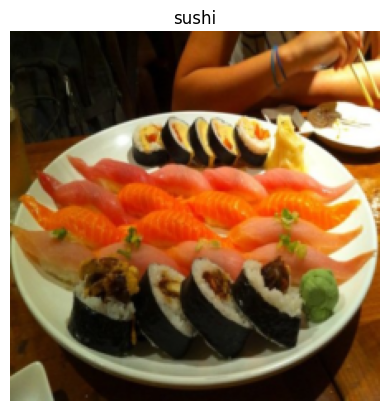

In [26]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape? {image.shape}")

# Turn image into feature maps
image_out_of_conv.unsqueeze(0) # add batch dimension
print(f" Image feature map (patches) shape {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [27]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> batch, number of patches, embedding dimension")

torch.Size([1, 196, 768]) -> batch, number of patches, embedding dimension


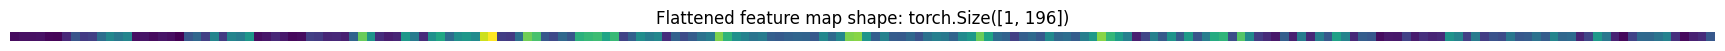

In [28]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the Vit patch embedding layer into a Pytorch module
We want this module to do a few thing
1. Create a class called Patch nn.Embedding
2. Initialize with appropriate hyperparameters, such as channels, embedding
dimension, patch size.
3. Create a layer to turn a image into embedding patches using nn.conv2d
4. Create a layer to flatten the feature maps of the output of layer in 3
5. Define a foward() computation
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [29]:
# Step 1: Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # From table 1 ViT
    super().__init__()

    self.patch_size = patch_size
    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # 4. Create a layer to flatten feature map outputs of COnv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
  # 5. Define a foward method to define the foward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size"

    # Perform the foward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make the returned sequence embedding dimensions are in the right order
    return x_flattened.permute(0, 2, 1)


In [30]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f" Output patch embedding sequence shape: {patch_embedded_image.shape}")

input image size: torch.Size([1, 3, 224, 224])
 Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [31]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

### 4.6 Creating the class token embedding
Wanto to: prepend a learnable class token to the start of the patch embedding

In [32]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [33]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [34]:
# Create class token embedding as a learnable parameter tha shares the same size as the embedding dimensiond (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [35]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number of patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepend shape: {patch_embedded_image_with_class_embedding.shape}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0563, -0.0073, -0.0471,  ...,  0.0417, -0.0199,  0.0135],
         [-0.0722,  0.0053, -0.0566,  ...,  0.0623, -0.0211,  0.0188],
         ...,
         [-0.1811, -0.0070, -0.0381,  ...,  0.1064, -0.0673,  0.0261],
         [-0.3864, -0.0043, -0.0174,  ...,  0.1867, -0.1572,  0.0600],
         [-0.3900,  0.0284, -0.0651,  ...,  0.2264, -0.1811,  0.1691]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepend shape: torch.Size([1, 197, 768])


### 4.7 Creating the position embedding

In [37]:
# View the sequence of patch embedding with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0563, -0.0073, -0.0471,  ...,  0.0417, -0.0199,  0.0135],
          [-0.0722,  0.0053, -0.0566,  ...,  0.0623, -0.0211,  0.0188],
          ...,
          [-0.1811, -0.0070, -0.0381,  ...,  0.1064, -0.0673,  0.0261],
          [-0.3864, -0.0043, -0.0174,  ...,  0.1867, -0.1572,  0.0600],
          [-0.3900,  0.0284, -0.0651,  ...,  0.2264, -0.1811,  0.1691]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
# Calculate N (Number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Getting the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [39]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and postion embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9437, 0.9927, 0.9529,  ..., 1.0417, 0.9801, 1.0135],
         [0.9278, 1.0053, 0.9434,  ..., 1.0623, 0.9789, 1.0188],
         ...,
         [0.8189, 0.9930, 0.9619,  ..., 1.1064, 0.9327, 1.0261],
         [0.6136, 0.9957, 0.9826,  ..., 1.1867, 0.8428, 1.0600],
         [0.6100, 1.0284, 0.9349,  ..., 1.2264, 0.8189, 1.1691]]],
       grad_fn=<AddBackward0>)
Patch and postion embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding


In [40]:
# Set the seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2.Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create a patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through patch embedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure its learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create the position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [41]:
image.shape

torch.Size([3, 224, 224])

## Equation 2: Multihead Self-Attention (MSA block)

In [44]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block (MSA)"""
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D (embedding dimension)
                 num_heads:int=12, # Heads from table 1 for VIT-Base
                 attn_dropout:int=0):
      # Create LayerNorm
      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

      # Create the MSA
      self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  dropout=attn_dropout,
                                                  batch_first=True) # batch, number of patches, embedding_dimension
    def foward(self, x):
      x = self.layer_norm(x)
      attn_output, _ = self.multihead_attn(query=x,
                                           key=x,
                                           value=x,
                                           need_weights=False)
      return attn_output

